In [ ]:
%matplotlib inline
from transformers import AutoTokenizer,AutoConfig
import torch 
import joblib 
import numpy as np
import pandas as pd
import pickle
import os
import re
import glob
import string
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm
import sys
sys.path.append('/home/jianing/generation/CRUISE_code')
from utils import get_segmentation_indices,segmentation_to_word_list,model_to_path_dict

In [2]:
def extract_windows(nperm,event_len,segmentation_indices_in_tokens):
    # windows around boundaries
    window_len = np.min(event_len)
    window_ce_around_boundary = []
    for idx in segmentation_indices_in_tokens[:-1]:
        ce_window = original_ce[idx-window_len:idx+window_len+1]
        window_ce_around_boundary.append(torch.sum(ce_window))
    window_ce_around_boundary = np.array(window_ce_around_boundary)
    
    # random windows
    rng = np.random.default_rng(0)
    choice_range = np.arange(window_len,max(segmentation_indices_in_tokens)-window_len)
    random_indices = rng.choice(choice_range, nperm)
    
    window_ce_random = []
    for idx in random_indices:
        ce_window = original_ce[idx-window_len:idx+window_len+1]
        window_ce_random.append(torch.sum(ce_window))
    window_ce_random = np.array(window_ce_random)
    thresh = np.percentile(window_ce_random,95)
    return window_ce_around_boundary,window_ce_random,thresh

In [4]:
model_name = 'Llama3-8b-instruct'
save_dir = '/home/jianing/generation/generated'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])

moth_output_dir = os.path.join(save_dir,model_save_dir_name,'moth_stories_output')
original_transcript_dir = '/home/jianing/generation/transcripts/moth_stories'
segmentation_dir = '/home/jianing/generation/behavior_data/segmentation'

stories = ['pieman','alternateithicatom','odetostepfather','souls','legacy','wheretheressmoke','adventuresinsayingyes','inamoment']
story_to_idx_mapping = {s:stories.index(s)+1 for s in stories}
results_dict = {}
nperm = 1000
results_df = []
for story in stories:
    with open(os.path.join(moth_output_dir,story,'cross_entropy.pkl'),'rb') as f:
        original_ce = pickle.load(f)
    # tokenized txt 
    with open(os.path.join(moth_output_dir,story,'tokenized_txt.pkl'),'rb') as f:
        tokenized_txt = pickle.load(f)
    story_tokens = torch.load(os.path.join(moth_output_dir,story,'tokens.pkl'),map_location=torch.device('cpu'))
    story_tokens = story_tokens[0,1:].cpu().detach()
    consensus_path = os.path.join(segmentation_dir,story,'%s_consensus.txt'%story)
    with open(consensus_path,'r') as f:
        consensus_txt = f.read()
    consensus_txt = consensus_txt.split('\n')
    with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
        original_txt = f.read()
    consensus_wordlist = segmentation_to_word_list(consensus_txt)
    segmentation_indices_in_tokens = get_segmentation_indices(tokenized_txt,consensus_wordlist,original_txt,initial_char='Ġ')
    event_len = np.diff([0]+segmentation_indices_in_tokens)
    event_len[0]+=1
    window_ce_around_boundary,window_ce_random,thresh = extract_windows(nperm,event_len,segmentation_indices_in_tokens)
    results_dict[story] = {'window_ce_around_boundary':window_ce_around_boundary,
                          'window_ce_random':window_ce_random,
                          'thresh':thresh}
    values = np.concatenate((window_ce_around_boundary,window_ce_random))
    condition = np.concatenate((np.repeat('boundary',len(window_ce_around_boundary)),np.repeat('random',len(window_ce_random))))
    story_results_df = pd.DataFrame({'window_ce':values,'condition':condition,'story':'Story '+str(story_to_idx_mapping[story])})
    results_df.append(story_results_df)
results_df = pd.concat(results_df,ignore_index = True)

In [5]:
results_dict.keys()

dict_keys(['pieman', 'alternateithicatom', 'odetostepfather', 'souls', 'legacy', 'wheretheressmoke', 'adventuresinsayingyes', 'inamoment'])

/opt/miniconda3/envs/torch/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:grey'` for same effect.
  warnings.warn(msg, FutureWarning)


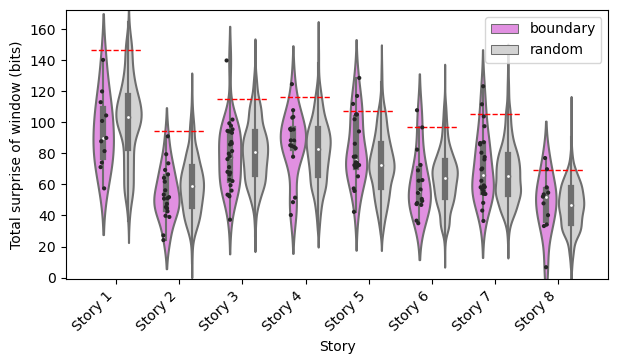

In [6]:
fig,ax = plt.subplots(figsize = (7,3.5))
sns.violinplot(data=results_df, x="story", y="window_ce", hue="condition",ax=ax,
               inner = 'box',palette=["violet", "lightgrey"])
boundary_df = results_df[results_df["condition"] == "boundary"]
sns.stripplot(
    data=boundary_df,
    x="story",
    y="window_ce",
    hue="condition", 
    dodge=True,
    color="grey",     # override hue colors
    size=3,
    ax=ax,
    hue_order=['boundary','random']
)
# After both plots:
handles, labels = ax.get_legend_handles_labels()

# Keep only unique condition labels — drop stripplot duplicates
n_conditions = results_df["condition"].nunique()
ax.legend(handles[:n_conditions], labels[:n_conditions])

ax.set_ylabel('Total surprise of window (bits)')
ax.set_xlabel('Story')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, ha='right')

# add 95% threshold
# Get the x positions for each story from the plot's x-axis categories
xticks = ax.get_xticks()       # numeric positions, e.g. [0,1,2,...]
xticklabels = ax.get_xticklabels()
story_to_x = {label.get_text(): pos for label, pos in zip(xticklabels, xticks)}

# Width of each violin's horizontal space (adjust if needed)
width = 0.4

for story in stories:
    y = results_dict[story]['thresh']
    story_idx = 'Story '+str(story_to_idx_mapping[story])
    x = story_to_x.get(story_idx)
    if x is not None:
        # Draw horizontal line centered at x, spanning width
        ax.hlines(y, x - width, x + width, colors='red', linestyles='--', linewidth=1)
#fig.savefig(os.path.join(save_dir,model_save_dir_name,'ce_around_boundary','boundary_ce_perm_result_new.svg'),transparent = True)

## check surprisal rate around boundaries 

In [7]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll
    return None,None

In [14]:
model_name = 'Llama3-8b-instruct'
save_dir = '/home/jianing/generation/generated'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])

moth_output_dir = os.path.join(save_dir,model_save_dir_name,'moth_stories_output')
original_transcript_dir = '/home/jianing/generation/transcripts/moth_stories'
segmentation_dir = '/home/jianing/generation/behavior_data/segmentation'
timing_dir = '/home/jianing/generation/transcripts/timing'
stories = ['pieman','alternateithicatom','odetostepfather','souls','legacy','wheretheressmoke','adventuresinsayingyes','inamoment']

In [23]:
# num window tokens to the left of boundary, num window tokens to the right of boundary
window = 14 # this gives 10 words to the left, 10 words to the right
story_big_dfs ={}
story_segmentation_indices_in_tokens={}
for story in stories:
    with open(os.path.join(moth_output_dir,story,'cross_entropy.pkl'),'rb') as f:
        original_ce = pickle.load(f)
    # tokenized txt 
    with open(os.path.join(moth_output_dir,story,'tokenized_txt.pkl'),'rb') as f:
        tokenized_txt = pickle.load(f)
    story_tokens = torch.load(os.path.join(moth_output_dir,story,'tokens.pkl'),map_location=torch.device('cpu'))
    story_tokens = story_tokens[0,1:].cpu().detach()
    consensus_path = os.path.join(segmentation_dir,story,'%s_consensus.txt'%story)
    with open(consensus_path,'r') as f:
        consensus_txt = f.read()
    consensus_txt = consensus_txt.split('\n')
    with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
        original_txt = f.read()
    consensus_wordlist = segmentation_to_word_list(consensus_txt)
    segmentation_indices_in_tokens = get_segmentation_indices(tokenized_txt,consensus_wordlist,original_txt,initial_char='Ġ')
    event_len = np.diff([0]+segmentation_indices_in_tokens)
    event_len[0]+=1
    filtered_segmentation_indices_in_tokens = segmentation_indices_in_tokens[:-1].copy()
    story_segmentation_indices_in_tokens[story] = segmentation_indices_in_tokens
    
    timing_df = pd.read_csv(os.path.join(timing_dir,'%s_timing.csv'%story))
    
    if len(timing_df) != len(consensus_wordlist):
        empty_string_idx = []
        for i in range(len(consensus_wordlist)):
            if consensus_wordlist[i] =='':
                print(i)
                empty_string_idx.append(i)
        for idx in empty_string_idx:
            row = pd.DataFrame({"text": '', "start": np.nan,"stop":np.nan}, index=[idx])
            timing_df = pd.concat([timing_df.iloc[:idx], row, timing_df.iloc[idx:]]).reset_index(drop=True)
    if story =='souls':
        timing_df['text'] = [t[:-1] if t!= '' and t[-1] == ' ' else t for t in timing_df['text']]
    assert len(timing_df) == len(consensus_wordlist)
    timing_word_list = [t if isinstance(t,str) else '' for t in list(timing_df['text'].values)]
    timing_word_list_low = [x.lower() for x in timing_word_list]
    assert ' '.join(timing_word_list).lower() == original_txt
    
    idx_of_boundaries = [i for i,w in enumerate(consensus_wordlist) if '\n' in w]
    num_events = len(consensus_txt)
    start_token_indices = []
    end_token_indices = []
    chunk_txt = []
    timing_word_list_start_indices = []
    timing_word_list_end_indices = []
    word_list_start_idx = 0
    word_list_end_idx = 1
    all_chunk_dfs =[]
    for idx in segmentation_indices_in_tokens[:-1]:
        start_idx = idx-window
        end_idx = idx+window
        if start_idx<0 or end_idx>original_ce.shape[0]:
            filtered_segmentation_indices_in_tokens=[i for i in filtered_segmentation_indices_in_tokens if i != idx]
            continue
        if start_idx!=0:
            while model_initial_char not in tokenized_txt[start_idx]:
                start_idx-=1
        if end_idx<len(tokenized_txt):
            while model_initial_char not in tokenized_txt[end_idx]:
                end_idx+=1
        this_chunk_txt = tokenizer.decode(story_tokens[start_idx:end_idx]) 
        if this_chunk_txt not in original_txt:
            this_chunk_txt = ''.join([s.replace(model_initial_char,' ') for s in tokenized_txt[start_idx:end_idx]]) 
            if this_chunk_txt not in original_txt:
                print(this_chunk_txt)
        assert this_chunk_txt in original_txt
        start_token_indices.append(start_idx)
        end_token_indices.append(end_idx)
        chunk_txt.append(this_chunk_txt)
        
        # match word to tokens
        word_list = []
        token_indices = []
        for i,t in enumerate(tokenized_txt[start_idx:end_idx]):
            if model_initial_char in t or i==0:
                word = t.replace(model_initial_char,' ')
                word_list.append(word)
                token_indices.append([start_idx+i])
            else:
                word_list[-1]+=t
                token_indices[-1].extend([start_idx+i])
        word_ce = np.array([torch.sum(original_ce[i]) for i in token_indices]) # sum of all tokens in the word
                
        joined_text = ' '.join(timing_word_list[word_list_start_idx:word_list_end_idx]).lower()
        if len(joined_text)>0 and joined_text[0] == ' ':
            joined_text = joined_text[1:]
        if this_chunk_txt[0] == ' ':
            this_chunk_txt = this_chunk_txt[1:]
#         if this_chunk_txt[-1] == ' ':
#             this_chunk_txt = this_chunk_txt[:-1]
        this_chunk_txt_list = this_chunk_txt.lower().split(' ')
        word_list_start_idx,word_list_end_idx = find_sub_list(this_chunk_txt_list,timing_word_list_low)
        assert word_list_start_idx is not None
        timing_word_list_start_indices.append(word_list_start_idx)
        timing_word_list_end_indices.append(word_list_end_idx)
        chunk_timings = timing_df.iloc[word_list_start_idx:word_list_end_idx]
        assert len(chunk_timings)==len(word_list)
        df = pd.DataFrame({'word':word_list,'token_indices':token_indices,'word_ce':word_ce})
        big_df = pd.concat([df.reset_index(drop=True), chunk_timings.reset_index(drop=True)],axis = 1)
        all_chunk_dfs.append(big_df)
    story_big_dfs[story]=all_chunk_dfs
    story_segmentation_indices_in_tokens[story] = filtered_segmentation_indices_in_tokens

455
459


# x axis as word index 

In [24]:
max_len = 100
for story in story_big_dfs.keys():
    segmentation_indices_in_tokens = story_segmentation_indices_in_tokens[story]
    all_chunk_dfs = story_big_dfs[story]
    for i,seg_idx in enumerate(segmentation_indices_in_tokens):
        big_df = all_chunk_dfs[i]
        seg_idx_in_big_df= -1
        for df_idx,row in big_df.iterrows():
            if seg_idx in row['token_indices']:
                seg_idx_in_big_df=df_idx
                break

        this_max_len = np.min([seg_idx_in_big_df,len(big_df)-1-seg_idx_in_big_df])
        if this_max_len<max_len:
            max_len = this_max_len
print(max_len)
#max_len = int(np.floor(np.min([len(df) for df in all_chunk_dfs])/2))

10


In [26]:
story_plot_arrays_info_rate = {}
story_plot_arrays_speech_rate = {}
story_plot_arrays_surprisal = {}
for story in story_big_dfs.keys():
    segmentation_indices_in_tokens = story_segmentation_indices_in_tokens[story]
    all_chunk_dfs = story_big_dfs[story]
    plot_arrays_info_rate = np.zeros((len(segmentation_indices_in_tokens),int(max_len)*2+1))
    plot_arrays_speech_rate = np.zeros((len(segmentation_indices_in_tokens),int(max_len)*2+1))
    plot_arrays_surprisal =np.zeros((len(segmentation_indices_in_tokens),int(max_len)*2+1))
    for i,seg_idx in enumerate(segmentation_indices_in_tokens):
        big_df = all_chunk_dfs[i]
        # find where the segmentation point is 
        seg_idx_in_big_df= -1
        for df_idx,row in big_df.iterrows():
            if seg_idx in row['token_indices']:
                seg_idx_in_big_df=df_idx
                break
        assert seg_idx_in_big_df!= -1
        
        new_stop =big_df['stop'].values
        # extend the end time to the start time of the next word
        for row_idx,val in enumerate(big_df['stop'][:len(big_df)-1]):
            if val<big_df['start'][row_idx+1]:
                new_stop[row_idx]=big_df['start'][row_idx+1]
        if story=='pieman':
            duration = (new_stop-big_df['start'])/1000
        else:
            duration = (new_stop-big_df['start'])
        info_rate = big_df['word_ce']/duration
        centered_info_rate = info_rate[seg_idx_in_big_df-max_len:seg_idx_in_big_df+max_len+1]
        speech_rate = 1/duration
        centered_speech_rate = speech_rate[seg_idx_in_big_df-max_len:seg_idx_in_big_df+max_len+1]
        #print(len(centered_info_rate))
        plot_arrays_info_rate[i] = centered_info_rate
        plot_arrays_speech_rate[i]=centered_speech_rate
        plot_arrays_surprisal[i]=big_df['word_ce'][seg_idx_in_big_df-max_len:seg_idx_in_big_df+max_len+1]
    story_plot_arrays_info_rate[story]=plot_arrays_info_rate
    story_plot_arrays_speech_rate[story]=plot_arrays_speech_rate
    story_plot_arrays_surprisal[story] = plot_arrays_surprisal

## average across stories, plot standard error

In [27]:
colors = sns.color_palette("Spectral", 5)
fontsize = 9

In [28]:
bin_duration = 0.5 #s
seconds = 5
num_bins = int(seconds/bin_duration) # on each side 

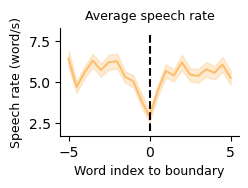

In [29]:
# calculate mean and standard error 
all_plot_arrays_by_word = []
for i,story in enumerate(story_big_dfs.keys()):
    all_plot_arrays_by_word.append(story_plot_arrays_speech_rate[story])
all_plot_arrays_by_word = np.concatenate(all_plot_arrays_by_word)
nanmean = np.nanmean(all_plot_arrays_by_word,axis =0)
yerr = np.nanstd(all_plot_arrays_by_word,axis =0)/np.sqrt(len(all_plot_arrays_by_word))

fig,ax = plt.subplots(figsize = (2.3,1.4))
xx=np.linspace(-bin_duration*num_bins,bin_duration*num_bins,num_bins*2+1)
plt.plot(xx,nanmean,color = colors[1])
plt.fill_between(xx, nanmean-yerr, nanmean+yerr,alpha=0.3,color = colors[1])
plt.vlines(x=0,ymin=2,ymax = 8,linestyles='dashed',color='black')

plt.xlabel('Word index to boundary',fontsize = fontsize)
plt.ylabel('Speech rate (word/s)',fontsize = fontsize)
plt.title('Average speech rate',fontsize = fontsize)
sns.despine()
#fig.savefig(os.path.join(save_dir,model_save_dir_name,'ce_around_boundary','speech_rate_by_word.svg'),transparent = True)

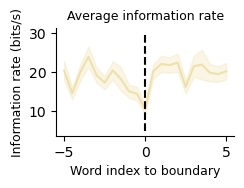

In [30]:
# calculate mean and standard error 
all_plot_arrays_by_word = []
for i,story in enumerate(story_big_dfs.keys()):
    all_plot_arrays_by_word.append(story_plot_arrays_info_rate[story])
all_plot_arrays_by_word = np.concatenate(all_plot_arrays_by_word)
nanmean = np.nanmean(all_plot_arrays_by_word,axis =0)
yerr = np.nanstd(all_plot_arrays_by_word,axis =0)/np.sqrt(len(all_plot_arrays_by_word))

fig,ax = plt.subplots(figsize = (2.3,1.4))
xx=np.linspace(-bin_duration*num_bins,bin_duration*num_bins,num_bins*2+1)
plt.plot(xx,nanmean,color = '#efe1aaff')
plt.fill_between(xx, nanmean-yerr, nanmean+yerr,alpha=0.3,color = '#efe1aaff')
plt.vlines(x=0,ymin=5,ymax = 30,linestyles='dashed',color='black')

plt.xlabel('Word index to boundary',fontsize = fontsize)
plt.ylabel('Information rate (bits/s)',fontsize = fontsize)
plt.title('Average information rate',fontsize = fontsize)
sns.despine()
#fig.savefig(os.path.join(save_dir,model_save_dir_name,'ce_around_boundary','info_rate_by_word.svg'),transparent = True)

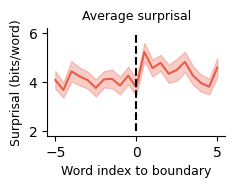

In [715]:
# calculate mean and standard error 
all_plot_arrays_by_word = []
for i,story in enumerate(story_big_dfs.keys()):
    all_plot_arrays_by_word.append(story_plot_arrays_surprisal[story])
all_plot_arrays_by_word = np.concatenate(all_plot_arrays_by_word)
nanmean = np.nanmean(all_plot_arrays_by_word,axis =0)
yerr = np.nanstd(all_plot_arrays_by_word,axis =0)/np.sqrt(len(all_plot_arrays_by_word))

fig,ax = plt.subplots(figsize = (2.3,1.4))
xx=np.linspace(-bin_duration*num_bins,bin_duration*num_bins,num_bins*2+1)
plt.plot(xx,nanmean,color = colors[0])
plt.fill_between(xx, nanmean-yerr, nanmean+yerr,alpha=0.3,color = colors[0])
plt.vlines(x=0,ymin=2,ymax = 6,linestyles='dashed',color='black')

plt.xlabel('Word index to boundary',fontsize = fontsize)
plt.ylabel('Surprisal (bits/word)',fontsize = fontsize)
plt.title('Average surprisal',fontsize = fontsize)
sns.despine()
fig.savefig(os.path.join(save_dir,model_save_dir_name,'ce_around_boundary','surprisal_by_word.svg'),transparent = True)

# x axis as time 

In [32]:
# num window tokens to the left of boundary, num window tokens to the right of boundary
#window = 14 # this gives 10 words to the left, 10 words to the right
window = 30
story_big_dfs2 ={}
story_segmentation_indices_in_tokens2={}
story_start_end_time ={}
for story in stories:
    with open(os.path.join(moth_output_dir,story,'cross_entropy.pkl'),'rb') as f:
        original_ce = pickle.load(f)
    # tokenized txt 
    with open(os.path.join(moth_output_dir,story,'tokenized_txt.pkl'),'rb') as f:
        tokenized_txt = pickle.load(f)
    story_tokens = torch.load(os.path.join(moth_output_dir,story,'tokens.pkl'),map_location=torch.device('cpu'))
    story_tokens = story_tokens[0,1:].cpu().detach()
    consensus_path = os.path.join(segmentation_dir,story,'%s_consensus.txt'%story)
    with open(consensus_path,'r') as f:
        consensus_txt = f.read()
    consensus_txt = consensus_txt.split('\n')
    with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
        original_txt = f.read()
    consensus_wordlist = segmentation_to_word_list(consensus_txt)
    segmentation_indices_in_tokens = get_segmentation_indices(tokenized_txt,consensus_wordlist,original_txt,initial_char='Ġ')
    event_len = np.diff([0]+segmentation_indices_in_tokens)
    event_len[0]+=1
    filtered_segmentation_indices_in_tokens = segmentation_indices_in_tokens[:-1].copy()
    
    
    timing_df = pd.read_csv(os.path.join(timing_dir,'%s_timing.csv'%story))
    
    if len(timing_df) != len(consensus_wordlist):
        empty_string_idx = []
        for i in range(len(consensus_wordlist)):
            if consensus_wordlist[i] =='':
                print(i)
                empty_string_idx.append(i)
        for idx in empty_string_idx:
            row = pd.DataFrame({"text": '', "start": np.nan,"stop":np.nan}, index=[idx])
            timing_df = pd.concat([timing_df.iloc[:idx], row, timing_df.iloc[idx:]]).reset_index(drop=True)
    if story =='souls':
        timing_df['text'] = [t[:-1] if t!= '' and t[-1] == ' ' else t for t in timing_df['text']]
    assert len(timing_df) == len(consensus_wordlist)
    timing_word_list = [t if isinstance(t,str) else '' for t in list(timing_df['text'].values)]
    timing_word_list_low = [x.lower() for x in timing_word_list]
    assert ' '.join(timing_word_list).lower() == original_txt
    
    idx_of_boundaries = [i for i,w in enumerate(consensus_wordlist) if '\n' in w]
    num_events = len(consensus_txt)
    start_token_indices = []
    end_token_indices = []
    chunk_txt = []
    timing_word_list_start_indices = []
    timing_word_list_end_indices = []
    word_list_start_idx = 0
    word_list_end_idx = 1
    all_chunk_dfs =[]
    for idx in segmentation_indices_in_tokens[:-1]:
        start_idx = idx-window
        end_idx = idx+window
        # if start_idx or end_idx is out of story range, set to start/end of story
        if start_idx<0:
            start_idx =0
        if end_idx>original_ce.shape[0]:
            end_idx = original_ce.shape[0]
        # make sure start_idx and end_idx correspond to word start/end
        if start_idx!=0:
            while model_initial_char not in tokenized_txt[start_idx]:
                start_idx-=1
        if end_idx<len(tokenized_txt):
            while model_initial_char not in tokenized_txt[end_idx]:
                end_idx+=1
        this_chunk_txt = tokenizer.decode(story_tokens[start_idx:end_idx])
        if this_chunk_txt not in original_txt:
            this_chunk_txt = ''.join([s.replace(model_initial_char,' ') for s in tokenized_txt[start_idx:end_idx]]) 
            if this_chunk_txt not in original_txt:
                print(this_chunk_txt)
        assert this_chunk_txt in original_txt
        start_token_indices.append(start_idx)
        end_token_indices.append(end_idx)
        chunk_txt.append(this_chunk_txt)
        
        # match word to tokens
        word_list = []
        token_indices = []
        for i,t in enumerate(tokenized_txt[start_idx:end_idx]):
            if model_initial_char in t or i==0:
                word = t.replace(model_initial_char,' ')
                word_list.append(word)
                token_indices.append([start_idx+i])
            else:
                word_list[-1]+=t
                token_indices[-1].extend([start_idx+i])
        word_ce = np.array([torch.sum(original_ce[i]) for i in token_indices]) # sum of all tokens in the word
                
        joined_text = ' '.join(timing_word_list[word_list_start_idx:word_list_end_idx]).lower()
        if len(joined_text)>0 and joined_text[0] == ' ':
            joined_text = joined_text[1:]
        if this_chunk_txt[0] == ' ':
            this_chunk_txt = this_chunk_txt[1:]
#         if this_chunk_txt[-1] == ' ':
#             this_chunk_txt = this_chunk_txt[:-1]
        this_chunk_txt_list = this_chunk_txt.lower().split(' ')
        word_list_start_idx,word_list_end_idx = find_sub_list(this_chunk_txt_list,timing_word_list_low)

        assert word_list_start_idx is not None
        timing_word_list_start_indices.append(word_list_start_idx)
        timing_word_list_end_indices.append(word_list_end_idx)
        chunk_timings = timing_df.iloc[word_list_start_idx:word_list_end_idx]
        assert len(chunk_timings)==len(word_list)
        df = pd.DataFrame({'word':word_list,'token_indices':token_indices,'word_ce':word_ce})
        big_df = pd.concat([df.reset_index(drop=True), chunk_timings.reset_index(drop=True)],axis = 1)
        if story=='pieman':
            big_df['start'] = big_df['start']/1000
            big_df['stop'] = big_df['stop']/1000
        all_chunk_dfs.append(big_df)
    story_big_dfs2[story]=all_chunk_dfs
    story_segmentation_indices_in_tokens2[story] = segmentation_indices_in_tokens[:-1]
    story_start_end_time[story] = np.array([timing_df.iloc[0]['start'],timing_df.iloc[len(timing_df)-1]['stop']])
    if story=='pieman':
        story_start_end_time[story]/=1000

455
459


In [39]:
include_if_midpoint = True # if true, count word to be in the bin if the midpoint is in the bin. Else count word if any part of it is in the bin 
bin_duration = 0.5 #s
seconds = 5
num_bins = int(seconds/bin_duration) # on each side 
story_plot_arrays_info_rate2 = {}
story_plot_arrays_speech_rate2 = {}
story_plot_arrays_surprisal2 = {}
for story in story_big_dfs2.keys():
    segmentation_indices_in_tokens = story_segmentation_indices_in_tokens2[story] # this already doesn't have the index of the end of story
    this_story_start_end = story_start_end_time[story]
    all_chunk_dfs = story_big_dfs2[story]
    plot_arrays_info_rate = np.ones((len(segmentation_indices_in_tokens),num_bins*2+1))*np.nan
    plot_arrays_speech_rate = np.ones((len(segmentation_indices_in_tokens),num_bins*2+1))*np.nan
    plot_arrays_surprisal = np.ones((len(segmentation_indices_in_tokens),num_bins*2+1))*np.nan
    for i,seg_idx in enumerate(segmentation_indices_in_tokens):
        big_df = all_chunk_dfs[i]
        
        # find where the segmentation point is 
        seg_idx_in_big_df= -1
        for df_idx,row in big_df.iterrows():
            if seg_idx in row['token_indices']:
                seg_idx_in_big_df=df_idx
                break
        assert seg_idx_in_big_df!= -1
        # segmentation time has to be the mid point between two events, otherwise one bin is guaranteed to get a word 
        segmentation_time = (big_df['stop'].iloc[seg_idx_in_big_df]+big_df['start'].iloc[seg_idx_in_big_df+1])/2 # midpoint between end of last event and start of the next, this will be the center of the middle bin
        
        # the end of the middle bin is the segmentation time
        range_start = segmentation_time-(num_bins+1)*bin_duration
        range_end = segmentation_time+(num_bins)*bin_duration
        bin_edges = np.linspace(range_start,range_end,num_bins*2+1+1) # num_bins*2+1+1 because linspace gives that many numbers, and we need num_bins*2+1 intervals
        # if an edge is smaller than story start time or later than story end time, throw out the bin 
        bin_edges = [edge if edge>=this_story_start_end[0] and edge<=this_story_start_end[1] else np.nan for edge in bin_edges]
        bin_edges_start = bin_edges[:-1]
        bin_edges_end = bin_edges[1:]
        
        new_stop =big_df['stop'].values.copy()
        word_mid_point = (new_stop+big_df['start'].values)/2

        for bin_idx,(bin_start,bin_end) in enumerate(zip(bin_edges_start,bin_edges_end)):
            word_indices_in_bin=[]
            if np.isnan(bin_start):
                continue
            if include_if_midpoint:
                word_indices_in_bin = [idx for idx,timing in enumerate(word_mid_point) if timing>=bin_start and timing<=bin_end]
            else:
                for row_idx,row in big_df.iterrows():
                    if row['start']<bin_start and row['stop']>bin_start:
                        word_indices_in_bin.append(row_idx)
                    elif row['start']<bin_end and row['stop']>bin_end:
                        word_indices_in_bin.append(row_idx)
                    elif row['start']>bin_start and row['stop']<bin_end:
                        word_indices_in_bin.append(row_idx)
#             if len(word_indices_in_bin)==0:
#                 print(seg_idx,bin_start,bin_end)
                
            #print(word_indices_in_bin)
            speech_rate = len(word_indices_in_bin)/bin_duration
            bin_ce = np.sum(big_df.iloc[word_indices_in_bin]['word_ce'])
            info_rate = bin_ce/bin_duration
            surprisal = np.mean(big_df.iloc[word_indices_in_bin]['word_ce'])
            plot_arrays_speech_rate[i,bin_idx]=speech_rate
            plot_arrays_info_rate[i,bin_idx] = info_rate
            plot_arrays_surprisal[i,bin_idx] = surprisal
        
    story_plot_arrays_info_rate2[story]=plot_arrays_info_rate
    story_plot_arrays_speech_rate2[story]=plot_arrays_speech_rate
    story_plot_arrays_surprisal2[story] = plot_arrays_surprisal

## average across stories, plot standard error

In [34]:
colors = sns.color_palette("Spectral", 5)
fontsize = 9

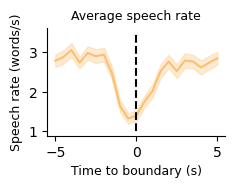

In [40]:
# calculate mean and standard error 
all_plot_arrays = []
for i,story in enumerate(story_big_dfs2.keys()):
    all_plot_arrays.append(story_plot_arrays_speech_rate2[story])
all_plot_arrays = np.concatenate(all_plot_arrays)
nanmean = np.nanmean(all_plot_arrays,axis =0)
yerr = np.nanstd(all_plot_arrays,axis =0)/np.sqrt(len(all_plot_arrays))

fig,ax = plt.subplots(figsize = (2.3,1.4))
xx=np.linspace(-bin_duration*num_bins,bin_duration*num_bins,num_bins*2+1)
plt.plot(xx,nanmean,color = colors[1])
plt.fill_between(xx, nanmean-yerr, nanmean+yerr,alpha=0.3,color = colors[1])
plt.vlines(x=0,ymin=1,ymax = 3.5,linestyles='dashed',color='black')

plt.xlabel('Time to boundary (s)',fontsize=fontsize)
plt.ylabel('Speech rate (words/s)',fontsize=fontsize)
plt.title('Average speech rate',fontsize=fontsize)
sns.despine()
#fig.savefig(os.path.join(save_dir,model_save_dir_name,'ce_around_boundary','speech_rate_by_time.svg'),transparent = True)

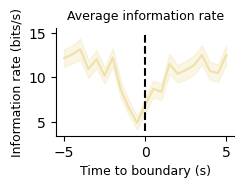

In [36]:
# calculate mean and standard error 
all_plot_arrays = []
for i,story in enumerate(story_big_dfs2.keys()):
    all_plot_arrays.append(story_plot_arrays_info_rate2[story])
all_plot_arrays = np.concatenate(all_plot_arrays)
nanmean = np.nanmean(all_plot_arrays,axis =0)
yerr = np.nanstd(all_plot_arrays,axis =0)/np.sqrt(len(all_plot_arrays))

fig,ax = plt.subplots(figsize = (2.3,1.4))
xx=np.linspace(-bin_duration*num_bins,bin_duration*num_bins,num_bins*2+1)
plt.plot(xx,nanmean,color = '#efe1aaff')
plt.fill_between(xx, nanmean-yerr, nanmean+yerr,alpha=0.3,color = '#efe1aaff')
plt.vlines(x=0,ymin=4,ymax = 15,linestyles='dashed',color='black')

plt.xlabel('Time to boundary (s)',fontsize=fontsize)
plt.ylabel('Information rate (bits/s)',fontsize=fontsize)
plt.title('Average information rate',fontsize=fontsize)
sns.despine()
#fig.savefig(os.path.join(save_dir,model_save_dir_name,'ce_around_boundary','info_rate_by_time.svg'),transparent = True)

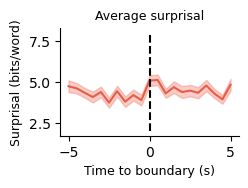

In [37]:
# calculate mean and standard error 
all_plot_arrays = []
for i,story in enumerate(story_big_dfs2.keys()):
    all_plot_arrays.append(story_plot_arrays_surprisal2[story])
all_plot_arrays = np.concatenate(all_plot_arrays)
nanmean = np.nanmean(all_plot_arrays,axis =0)
yerr = np.nanstd(all_plot_arrays,axis =0)/np.sqrt(len(all_plot_arrays))

fig,ax = plt.subplots(figsize = (2.3,1.4))
xx=np.linspace(-bin_duration*num_bins,bin_duration*num_bins,num_bins*2+1)
plt.plot(xx,nanmean,color = colors[0]) # the original color is too faint, so changed to this version
plt.fill_between(xx, nanmean-yerr, nanmean+yerr,alpha=0.3,color = colors[0])
plt.vlines(x=0,ymin=2,ymax = 8,linestyles='dashed',color='black')

plt.xlabel('Time to boundary (s)',fontsize=fontsize)
plt.ylabel('Surprisal (bits/word)',fontsize=fontsize)
plt.title('Average surprisal',fontsize=fontsize)
sns.despine()
#fig.savefig(os.path.join(save_dir,model_save_dir_name,'ce_around_boundary','surprisal_by_time.svg'),transparent = True)